In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator

# 랜덤시드 고정시키기

np.random.seed(3)

Using TensorFlow backend.


In [2]:
# 데이터 생성 - 훈련 데이터 각 2000개, 검증 데이터 각 300개, 테스트 데이터 각 300개

# 300*300을 50*50으로 줄여서 학습시키도록 한다. 
# 훈련 데이터 수가 클래스당 2000개이므로 배치 크기를 5로 지정하면 400번 배치를 수행해 한 에포크 돌아감

train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory('galaxy_train',target_size=(50, 50),batch_size=5,class_mode='categorical')

val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory('galaxy_val',target_size=(50, 50),batch_size=5,class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory('galaxy_test',target_size=(50,50),batch_size=5, shuffle=False, class_mode='categorical')

Found 6000 images belonging to 3 classes.
Found 900 images belonging to 3 classes.
Found 900 images belonging to 3 classes.


In [2]:
# 모델 생성하기

model = Sequential()
model.add(Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='Valid', activation='relu', input_shape=(50,50,3)))
model.add(MaxPooling2D(pool_size=(2,2), strides=(1,1), padding='Valid'))
model.add(Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='Valid', activation='relu', input_shape=(50,50,3)))
model.add(MaxPooling2D(pool_size=(2,2), strides=(1,1), padding='Valid'))
model.add(Flatten())
model.add(Dense(128, kernel_initializer='he_normal', activation='relu'))
model.add(Dense(3,kernel_initializer='he_normal', activation='softmax'))

# 맨 마지막 fully connected layer (Dense layer)는 클래스 개수(여기선 3)로 나오도록

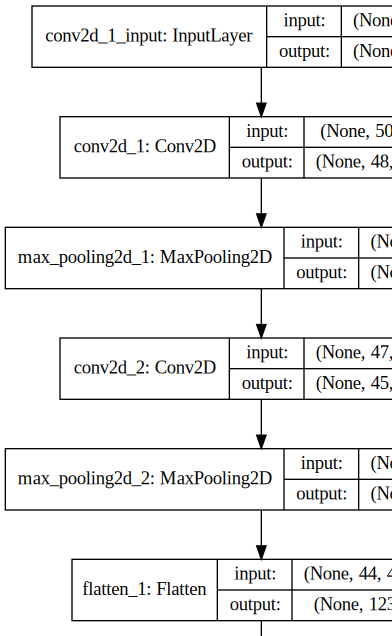

In [3]:
# 모델 가시화

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

%matplotlib inline

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [21]:
# 모델 학습과정 설정

from keras.optimizers import Adam

Optimizer = Adam(lr = 0.001)

model.compile(loss='categorical_crossentropy', optimizer=Optimizer, metrics=['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 48, 48, 32)        896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 44, 44, 64)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 123904)            0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               15859840  
_________________________________________________________________
dense_10 (Dense)             (None, 3)                

In [ ]:
# 모델 학습시키기

# steps_per_epoch: 총 6000개의 데이터이고 batch_size=5이므로 1200스텝
# validation_steps: 총 900개의 검증 샘플이 있고 batch_size=5이므로 180스텝

hist = model.fit_generator(train_generator, steps_per_epoch=1200, epochs=50, validation_data = val_generator, validation_steps=180)

In [ ]:
# 모델 평가하기 (훈련 데이터와 검증 데이터로 학습 후 맘에 들때까지 하이퍼 파리미터 (가중치 등) 조정하여 테스트 데이터로 평가)

print("-- Evaluate --")
scores = model.evaluate_generator(test_generator, steps=180)
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

In [ ]:
# 모델 사용하기 (테스트 데이터에 대해 예측하기 (또는 그냥 예측하고 싶은 데이터를 제너레이터로 만들어서 넣으면 됨))

print("-- Predict --")
output = model.predict_generator(test_generator, steps=180)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
print(test_generator.class_indices)
print(output)
print()
print('\n'.join(test_generator.filenames))

In [ ]:
# 학습과정 살펴보기

print(hist.history['loss'])
print(hist.history['acc'])
print(hist.history['val_loss'])
print(hist.history['val_acc'])

%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

acc_ax.plot(hist.history['acc'], 'b', label='train acc')
acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()